# Импорты

In [1]:
from transformers import AutoImageProcessor, SwinForImageClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoFeatureExtractor
from transformers import pipeline
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cpu


In [2]:
pipe = pipeline("image-classification", model="test_trainer", device=device)

/home/t1/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [167]:
from datasets import load_dataset
dataset = load_dataset("mvkvc/artifact-100k") # subset of ArtiFact labled with "ai" and "real" tags
dataset = dataset.with_format(type="torch", device=device)

batch_size = 20

model_name= 'microsoft/swin-base-patch4-window7-224'
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert('RGB') for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)

In [187]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image

y_score = []
y_target = []
for data in dataset["test"]:
    inp, targ = data["image"], data["label"]
    
    targ = float(targ)
    
    img = to_pil_image(inp)
    out = pipe(img)[1]["score"]
    y_target.append(targ)
    y_score.append(out)

0.71704262


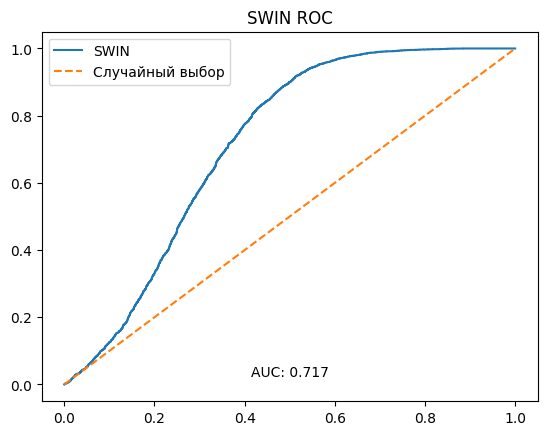

In [336]:
fpr, tpr, thresholds = metrics.roc_curve(y_target, y_score)
auc = metrics.roc_auc_score(y_target, y_score)
auc_text = f"AUC: {round(auc,3)}"
print(auc)

plt.title("SWIN ROC")
plt.plot(fpr,tpr, label="SWIN")
plt.plot([0,1],[0,1], label="Случайный выбор", linestyle="dashed")
plt.text(0.5,0.025,auc_text, horizontalalignment="center")
plt.legend()

In [331]:
with open("./swin_roc.npy", "wb") as f:
    np.save(f,np.row_stack((fpr,tpr)))

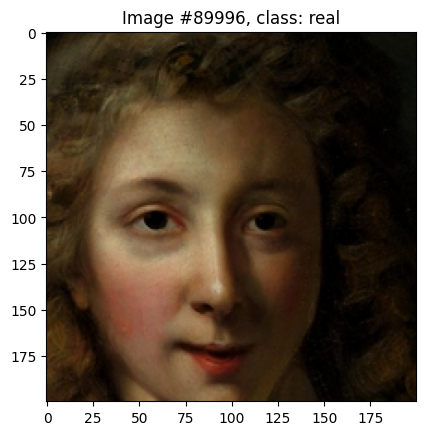

In [304]:
def get_label(ind):
    return dataset["train"].features['label'].names[ind]

def show_img(ind):
    l = len(dataset["train"])
    while ind < 0:
        ind += l
    data = dataset["train"][ind]
    plt.imshow(data["image"].permute(1, 2, 0))
    plt.title(f"Image #{ind}, class: {get_label(data['label'])}")

show_img(-4)